In [1]:
!pip install import-ipynb
import import_ipynb
#from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
import os
%load_ext autoreload
%autoreload 2

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=8e25e74e022645ec64675d6d16d7f97c4ba36e8338722d440f854a55061bc9df
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%cd "/content/gdrive/My Drive/Colab Notebooks/CNN_Utility"

/content/gdrive/My Drive/Colab Notebooks/CNN_Utility


In [0]:
#import sys
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/CNN_Utility')

In [6]:
ls

0-resnet18-gradcam-layer4.1.shortcut.png
10-resnet18-gradcam-layer4.1.shortcut.png
11-resnet18-gradcam-layer4.1.shortcut.png
12-resnet18-gradcam-layer4.1.shortcut.png
13-resnet18-gradcam-layer4.1.shortcut.png
14-resnet18-gradcam-layer4.1.shortcut.png
15-resnet18-gradcam-layer4.1.shortcut.png
16-resnet18-gradcam-layer4.1.shortcut.png
17-resnet18-gradcam-layer4.1.shortcut.png
18-resnet18-gradcam-layer4.1.shortcut.png
19-resnet18-gradcam-layer4.1.shortcut.png
1-resnet18-gradcam-layer4.1.shortcut.png
20-resnet18-gradcam-layer4.1.shortcut.png
21-resnet18-gradcam-layer4.1.shortcut.png
22-resnet18-gradcam-layer4.1.shortcut.png
23-resnet18-gradcam-layer4.1.shortcut.png
24-resnet18-gradcam-layer4.1.shortcut.png
2-resnet18-gradcam-layer4.1.shortcut.png
3-resnet18-gradcam-layer4.1.shortcut.png
4-resnet18-gradcam-layer4.1.shortcut.png
5-resnet18-gradcam-layer4.1.shortcut.png
6-resnet18-gradcam-layer4.1.shortcut.png
7-resnet18-gradcam-layer4.1.shortcut.png
8-resnet18-gradcam-layer4.1.shortcut.png
9

In [7]:
from dataloaders import train_test_dataloaders,transformations,AlbumentationWrapper
from models import BasicBlock,Bottleneck,ResNet,ResNet18,model_params,Net,model_params
from graphs_and_other_utility_functions import plot,save_model,get_lr,plot_misclassified_gradcam_images
from train_test import train,test
from lr_finder import LRFinder
import grad_cam
from main import demo1

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
train_transforms , test_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('test')

In [9]:
trainloader, testloader = train_test_dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


In [10]:
it=iter(trainloader)
data,target=next(it)
print(type(data))

<class 'torch.Tensor'>


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


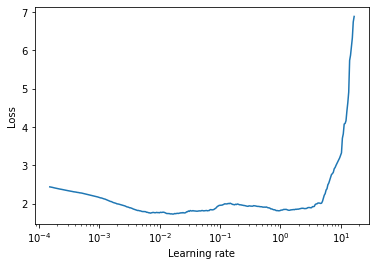

In [11]:
model =  ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=400)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, threshold=0.004, patience = 1, verbose=True)
epochs=50
input_size=(3,32,32)

  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Loss=1.236445665359497 Batch_id=390 Accuracy=50.67 running_loss=537.316960811615 threshold=996.0: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 5408/10000 (54.08%)

EPOCH: 1 LR: 0.02 537.316960811615 


Loss=0.6252143383026123 Batch_id=390 Accuracy=70.46 running_loss=326.4559020996094 threshold=535.1676929683686: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7349/10000 (73.49%)

EPOCH: 2 LR: 0.02 326.4559020996094 


Loss=0.7249572277069092 Batch_id=390 Accuracy=78.17 running_loss=241.71670404076576 threshold=325.15007849121093: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7757/10000 (77.57%)

EPOCH: 3 LR: 0.02 241.71670404076576 


Loss=0.49496349692344666 Batch_id=390 Accuracy=82.19 running_loss=199.48491623997688 threshold=240.7498372246027: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8029/10000 (80.29%)

EPOCH: 4 LR: 0.02 199.48491623997688 


Loss=0.4881582260131836 Batch_id=390 Accuracy=85.11 running_loss=167.02954868972301 threshold=198.68697657501698: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8019/10000 (80.19%)

EPOCH: 5 LR: 0.02 167.02954868972301 


Loss=0.44091635942459106 Batch_id=390 Accuracy=87.57 running_loss=139.58167001605034 threshold=166.3614304949641: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8231/10000 (82.31%)

EPOCH: 6 LR: 0.02 139.58167001605034 


Loss=0.34922775626182556 Batch_id=390 Accuracy=89.05 running_loss=120.8021976351738 threshold=139.02334333598614: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8328/10000 (83.28%)

EPOCH: 7 LR: 0.02 120.8021976351738 


Loss=0.18872714042663574 Batch_id=390 Accuracy=90.52 running_loss=106.3667249828577 threshold=120.3189888446331: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8487/10000 (84.87%)

EPOCH: 8 LR: 0.02 106.3667249828577 


Loss=0.18264615535736084 Batch_id=390 Accuracy=92.21 running_loss=87.21802458167076 threshold=105.94125808292627: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8388/10000 (83.88%)

EPOCH: 9 LR: 0.02 87.21802458167076 


Loss=0.13713517785072327 Batch_id=390 Accuracy=92.95 running_loss=77.61383806914091 threshold=86.86915248334408: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8185/10000 (81.85%)

EPOCH: 10 LR: 0.02 77.61383806914091 


Loss=0.10016058385372162 Batch_id=390 Accuracy=94.22 running_loss=64.97370927035809 threshold=77.30338271686435: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8578/10000 (85.78%)

EPOCH: 11 LR: 0.02 64.97370927035809 


Loss=0.2766954302787781 Batch_id=390 Accuracy=94.70 running_loss=58.556647192686796 threshold=64.71381443327665: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8486/10000 (84.86%)

EPOCH: 12 LR: 0.02 58.556647192686796 


Loss=0.08765475451946259 Batch_id=390 Accuracy=95.52 running_loss=49.22916280850768 threshold=58.32242060391605: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8622/10000 (86.22%)

EPOCH: 13 LR: 0.02 49.22916280850768 


Loss=0.051903463900089264 Batch_id=390 Accuracy=96.15 running_loss=42.74557771906257 threshold=49.03224615727365: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8618/10000 (86.18%)

EPOCH: 14 LR: 0.02 42.74557771906257 


Loss=0.20094843208789825 Batch_id=390 Accuracy=96.69 running_loss=37.66327676549554 threshold=42.57459540818632: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8596/10000 (85.96%)

EPOCH: 15 LR: 0.02 37.66327676549554 


Loss=0.15426680445671082 Batch_id=390 Accuracy=97.05 running_loss=32.47339405864477 threshold=37.512623658433554: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8626/10000 (86.26%)

EPOCH: 16 LR: 0.02 32.47339405864477 


Loss=0.0360381118953228 Batch_id=390 Accuracy=97.48 running_loss=28.39476564154029 threshold=32.34350048241019: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8646/10000 (86.46%)

EPOCH: 17 LR: 0.02 28.39476564154029 


Loss=0.09994007647037506 Batch_id=390 Accuracy=97.65 running_loss=26.704642483964562 threshold=28.28118657897413: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8631/10000 (86.31%)

EPOCH: 18 LR: 0.02 26.704642483964562 


Loss=0.012962925247848034 Batch_id=390 Accuracy=98.06 running_loss=21.513270781375468 threshold=26.597823914028705: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8647/10000 (86.47%)

EPOCH: 19 LR: 0.02 21.513270781375468 


Loss=0.018731599673628807 Batch_id=390 Accuracy=98.34 running_loss=18.14790171571076 threshold=21.427217698249965: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8574/10000 (85.74%)

EPOCH: 20 LR: 0.02 18.14790171571076 


Loss=0.06575523316860199 Batch_id=390 Accuracy=98.34 running_loss=18.492445189505816 threshold=18.075310108847916: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8536/10000 (85.36%)

EPOCH: 21 LR: 0.02 18.14790171571076 


Loss=0.06244021654129028 Batch_id=390 Accuracy=98.57 running_loss=16.70173260383308 threshold=18.075310108847916: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8704/10000 (87.04%)

EPOCH: 22 LR: 0.02 16.70173260383308 


Loss=0.048242609947919846 Batch_id=390 Accuracy=98.59 running_loss=15.542469874024391 threshold=16.634925673417747: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8538/10000 (85.38%)

EPOCH: 23 LR: 0.02 15.542469874024391 


Loss=0.1618877351284027 Batch_id=390 Accuracy=98.81 running_loss=13.802471924573183 threshold=15.480299994528293: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8667/10000 (86.67%)

EPOCH: 24 LR: 0.02 13.802471924573183 


Loss=0.05390577390789986 Batch_id=390 Accuracy=98.86 running_loss=12.72567425481975 threshold=13.74726203687489: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8765/10000 (87.65%)

EPOCH: 25 LR: 0.02 12.72567425481975 


Loss=0.052628230303525925 Batch_id=390 Accuracy=99.09 running_loss=10.458643211051822 threshold=12.674771557800472: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8717/10000 (87.17%)

EPOCH: 26 LR: 0.02 10.458643211051822 


Loss=0.10597164928913116 Batch_id=390 Accuracy=99.08 running_loss=10.225576631724834 threshold=10.416808638207614: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8696/10000 (86.96%)

EPOCH: 27 LR: 0.02 10.225576631724834 


Loss=0.14143384993076324 Batch_id=390 Accuracy=98.92 running_loss=12.42376341857016 threshold=10.184674325197935: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8757/10000 (87.57%)

EPOCH: 28 LR: 0.02 10.225576631724834 


Loss=0.005721378140151501 Batch_id=390 Accuracy=99.25 running_loss=8.425404242239892 threshold=10.184674325197935: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8749/10000 (87.49%)

EPOCH: 29 LR: 0.02 8.425404242239892 


Loss=0.02502650022506714 Batch_id=390 Accuracy=99.27 running_loss=8.333938280120492 threshold=8.391702625270932: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8710/10000 (87.10%)

EPOCH: 30 LR: 0.02 8.333938280120492 


Loss=0.024485206231474876 Batch_id=390 Accuracy=99.28 running_loss=8.834778442978859 threshold=8.30060252700001: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8772/10000 (87.72%)

EPOCH: 31 LR: 0.02 8.333938280120492 


Loss=0.010619068518280983 Batch_id=390 Accuracy=99.37 running_loss=7.233528742566705 threshold=8.30060252700001: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8814/10000 (88.14%)

EPOCH: 32 LR: 0.02 7.233528742566705 


Loss=0.002446293830871582 Batch_id=390 Accuracy=99.48 running_loss=6.4584555104374886 threshold=7.204594627596438: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8793/10000 (87.93%)

EPOCH: 33 LR: 0.02 6.4584555104374886 


Loss=0.002901411149650812 Batch_id=390 Accuracy=99.55 running_loss=5.618909731972963 threshold=6.432621688395739: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8789/10000 (87.89%)

EPOCH: 34 LR: 0.02 5.618909731972963 


Loss=0.04869136959314346 Batch_id=390 Accuracy=99.49 running_loss=5.854274403303862 threshold=5.596434093045071: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8759/10000 (87.59%)

EPOCH: 35 LR: 0.02 5.618909731972963 


Loss=0.018748372793197632 Batch_id=390 Accuracy=99.54 running_loss=5.157988423481584 threshold=5.596434093045071: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8785/10000 (87.85%)

EPOCH: 36 LR: 0.02 5.157988423481584 


Loss=0.03224160522222519 Batch_id=390 Accuracy=99.53 running_loss=5.303971003741026 threshold=5.137356469787657: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8763/10000 (87.63%)

EPOCH: 37 LR: 0.02 5.157988423481584 


Loss=0.008454096503555775 Batch_id=390 Accuracy=99.48 running_loss=5.788723603822291 threshold=5.137356469787657: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]

Epoch    38: reducing learning rate of group 0 to 2.0000e-03.



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8756/10000 (87.56%)

EPOCH: 38 LR: 0.002 5.157988423481584 


Loss=0.014223325066268444 Batch_id=390 Accuracy=99.80 running_loss=2.5951506597921252 threshold=5.137356469787657: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8881/10000 (88.81%)

EPOCH: 39 LR: 0.002 2.5951506597921252 


Loss=0.0013562440872192383 Batch_id=390 Accuracy=99.90 running_loss=1.4975652396678925 threshold=2.584770057152957: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8902/10000 (89.02%)

EPOCH: 40 LR: 0.002 1.4975652396678925 


Loss=0.0014934539794921875 Batch_id=390 Accuracy=99.94 running_loss=1.1572633869946003 threshold=1.491574978709221: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8905/10000 (89.05%)

EPOCH: 41 LR: 0.002 1.1572633869946003 


Loss=0.012427568435668945 Batch_id=390 Accuracy=99.94 running_loss=1.0313838720321655 threshold=1.1526343334466218: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8919/10000 (89.19%)

EPOCH: 42 LR: 0.002 1.0313838720321655 


Loss=0.0008264422649517655 Batch_id=390 Accuracy=99.94 running_loss=1.019735922687687 threshold=1.0272583365440369: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8921/10000 (89.21%)

EPOCH: 43 LR: 0.002 1.019735922687687 


Loss=0.0003703951952047646 Batch_id=390 Accuracy=99.97 running_loss=0.7231989883002825 threshold=1.0156569789969363: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8908/10000 (89.08%)

EPOCH: 44 LR: 0.002 0.7231989883002825 


Loss=0.0018803596030920744 Batch_id=390 Accuracy=99.96 running_loss=0.7539601929020137 threshold=0.7203061923470814: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8906/10000 (89.06%)

EPOCH: 45 LR: 0.002 0.7231989883002825 


Loss=0.0005025506252422929 Batch_id=390 Accuracy=99.98 running_loss=0.5956033744150773 threshold=0.7203061923470814: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8916/10000 (89.16%)

EPOCH: 46 LR: 0.002 0.5956033744150773 


Loss=3.78966324205976e-05 Batch_id=390 Accuracy=99.98 running_loss=0.5517797797911044 threshold=0.5932209609174169: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8916/10000 (89.16%)

EPOCH: 47 LR: 0.002 0.5517797797911044 


Loss=0.0001987695723073557 Batch_id=390 Accuracy=99.98 running_loss=0.4892881058185594 threshold=0.54957266067194: 100%|██████████| 391/391 [00:42<00:00,  9.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8908/10000 (89.08%)

EPOCH: 48 LR: 0.002 0.4892881058185594 


Loss=0.0010013222927227616 Batch_id=390 Accuracy=99.97 running_loss=0.5383686252171174 threshold=0.48733095339528515: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8907/10000 (89.07%)

EPOCH: 49 LR: 0.002 0.4892881058185594 


Loss=0.0014820576179772615 Batch_id=390 Accuracy=99.98 running_loss=0.4602493897546083 threshold=0.48733095339528515: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]



Test set: Average loss: 0.0045, Accuracy: 8916/10000 (89.16%)

mis classified length =  71820


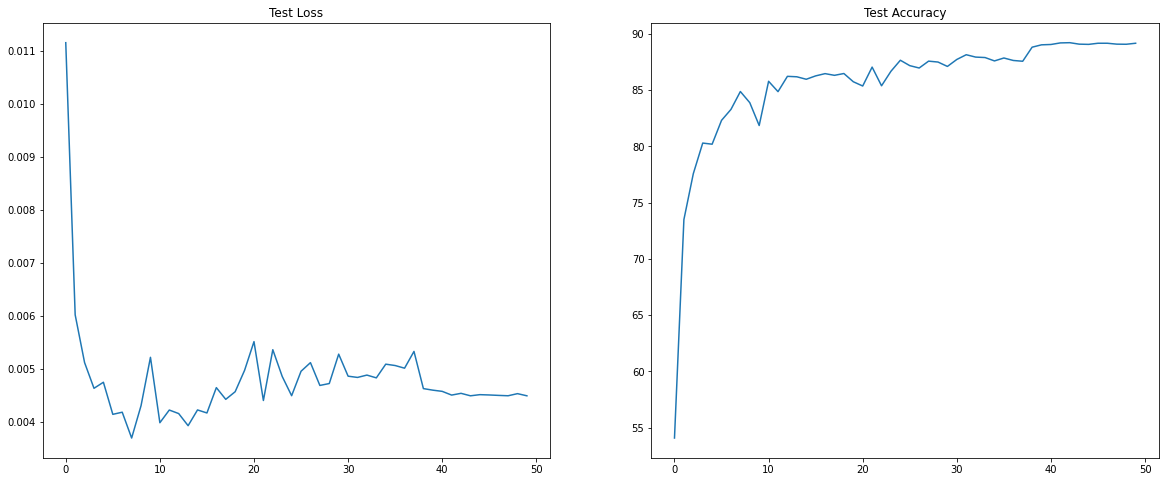

In [13]:
train_losses_without_L1_L2 = []
test_losses_without_L1_L2 = []
train_acc_without_L1_L2 = []
test_acc_without_L1_L2 = []
best_loss = 1000.0
misclassified_list = {}
model_params(model, input_size,device)  

for epoch in range(epochs):
    print("EPOCH: %s LR: %s %s " % (epoch, get_lr(optimizer),best_loss))
    best_loss=train(model, device, trainloader, optimizer, scheduler, epoch, False, train_acc_without_L1_L2, train_losses_without_L1_L2, best_loss)
    test(model, device, testloader, test_acc_without_L1_L2, test_losses_without_L1_L2, misclassified_list)
    #scheduler.step()
plot(train_losses_without_L1_L2,train_acc_without_L1_L2, test_losses_without_L1_L2, test_acc_without_L1_L2, 'without L1 and L2')
#save_model(model, '/content/gdrive/My Drive/Assign-8.pth')
print("mis classified length = ",len(misclassified_list))

In [0]:
gradcam_list=[]
for i in range(25):
  file_name = "Assign-10-"+str(i)+".png"
  gradcam_list.append(file_name)
  save_image(torch.from_numpy(misclassified_list[i][2]), file_name)

In [15]:
grad_image_list=demo1(gradcam_list,"layer4.1.shortcut","resnet18" ,10,"/content/gdrive/My Drive/Colab Notebooks/CNN_Utility", True, model)

Device: Tesla P100-PCIE-16GB
Images: ['Assign-10-0.png', 'Assign-10-1.png', 'Assign-10-2.png', 'Assign-10-3.png', 'Assign-10-4.png', 'Assign-10-5.png', 'Assign-10-6.png', 'Assign-10-7.png', 'Assign-10-8.png', 'Assign-10-9.png', 'Assign-10-10.png', 'Assign-10-11.png', 'Assign-10-12.png', 'Assign-10-13.png', 'Assign-10-14.png', 'Assign-10-15.png', 'Assign-10-16.png', 'Assign-10-17.png', 'Assign-10-18.png', 'Assign-10-19.png', 'Assign-10-20.png', 'Assign-10-21.png', 'Assign-10-22.png', 'Assign-10-23.png', 'Assign-10-24.png']
	#0: Assign-10-0.png
	#1: Assign-10-1.png
	#2: Assign-10-2.png
	#3: Assign-10-3.png
	#4: Assign-10-4.png
	#5: Assign-10-5.png
	#6: Assign-10-6.png
	#7: Assign-10-7.png
	#8: Assign-10-8.png
	#9: Assign-10-9.png
	#10: Assign-10-10.png
	#11: Assign-10-11.png
	#12: Assign-10-12.png
	#13: Assign-10-13.png
	#14: Assign-10-14.png
	#15: Assign-10-15.png
	#16: Assign-10-16.png
	#17: Assign-10-17.png
	#18: Assign-10-18.png
	#19: Assign-10-19.png
	#20: Assign-10-20.png
	#21: Ass

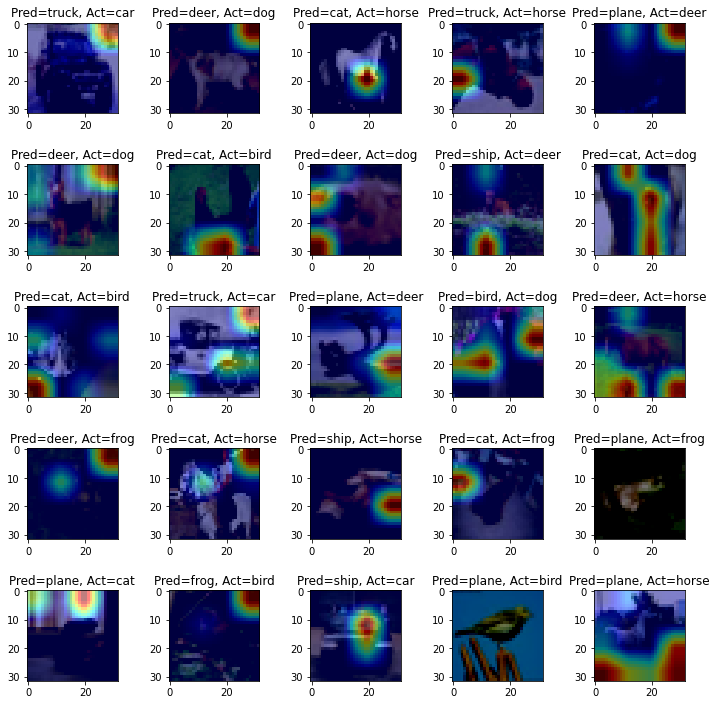

In [16]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_misclassified_gradcam_images(misclassified_list,grad_image_list, classes,'misclassified-gradcam-images.png')